In [27]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import contextily as ctx

from utils import init_postgis, get_location_error, crop_route, get_total_distance

In [2]:
matplotlib.rcParams['timezone'] = 'Asia/Singapore'

In [3]:
date = '27-05-2024'

In [4]:
input_dir = f"../data/{date}"
output_dir = f"../metadata/{date}"

In [9]:
start_location = (1.309743979078668, 103.89449080743935)
stop_location = (1.309743979078668, 103.89449080743935)

In [5]:
init_postgis('gpx_route', input_dir + '/route.gpx')
init_postgis('polar_route', input_dir + '/polar.gpx')
init_postgis('garmin_route', input_dir + '/garmin.gpx')

In [6]:
garmin_df = get_location_error('garmin_route')
garmin_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-05-27 06:18:43+08:00,1.309726,103.896459,227.860314
1,2024-05-27 06:18:49+08:00,1.309699,103.896454,226.840747
2,2024-05-27 06:18:56+08:00,1.309665,103.896435,224.407475


In [7]:
polar_df = get_location_error('polar_route')
polar_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-05-27 06:19:26.642000+08:00,1.309362,103.896368,216.058783
1,2024-05-27 06:19:27.641000+08:00,1.309362,103.896368,216.058783
2,2024-05-27 06:19:28.642000+08:00,1.309355,103.896353,214.430354


In [14]:
garmin_df = crop_route(garmin_df, start_location, stop_location, 200)
garmin_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
88,2024-05-27 06:25:40+08:00,1.307840,103.886418,5.718228,922.741839,922.741839
89,2024-05-27 06:25:42+08:00,1.307821,103.886381,4.553308,927.212939,927.212939
90,2024-05-27 06:25:45+08:00,1.307778,103.886327,1.110396,934.201472,934.201472


In [15]:
polar_df = crop_route(polar_df, start_location, stop_location, 200)
polar_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
320,2024-05-27 06:24:47.642000+08:00,1.308107,103.888087,4.348143,735.355654,735.355654
321,2024-05-27 06:24:48.642000+08:00,1.308098,103.888063,4.703561,738.100313,738.100313
322,2024-05-27 06:24:49.641000+08:00,1.308088,103.888048,5.436851,739.991047,739.991047


In [16]:
desc_polar_df = polar_df['distance_to_route'].describe().to_frame()
desc_polar_df.columns = ['Polar']

desc_garmin_df = garmin_df['distance_to_route'].describe().to_frame()
desc_garmin_df.columns = ['Garmin']

merged_desc = pd.concat([desc_polar_df, desc_garmin_df], axis=1)
merged_desc.to_csv('/tmp/merged_desc.csv')

print(merged_desc)

             Polar      Garmin
count  4338.000000  996.000000
mean      9.548493    6.553202
std      10.289296   10.055682
min       0.000022    0.002916
25%       2.800881    1.425565
50%       7.291996    3.639995
75%      12.573661    7.623708
max      80.102673   77.053014


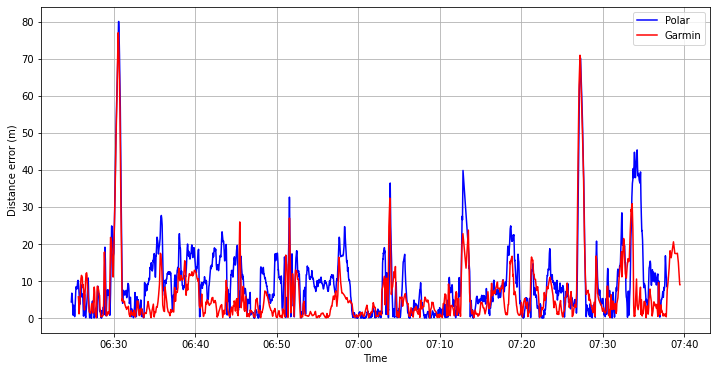

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(polar_df['time'], polar_df['distance_to_route'], color='blue', label='Polar')
plt.plot(garmin_df['time'], garmin_df['distance_to_route'], color='red', label='Garmin')
plt.xlabel('Time')
plt.ylabel('Distance error (m)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig(output_dir + '/location-error.png', bbox_inches='tight', facecolor='white')

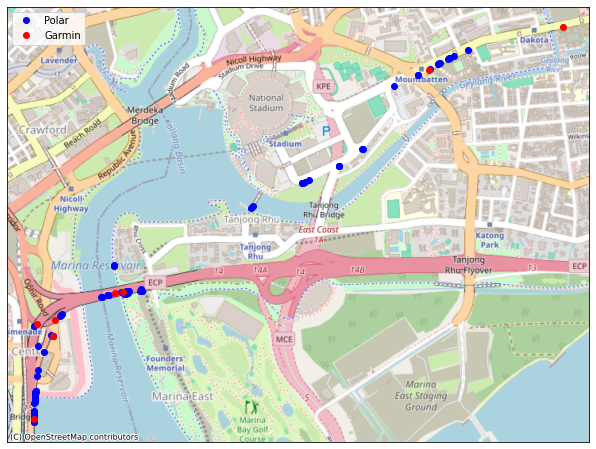

In [41]:
distance_error_threshold = 0.1
filtered_polar_df = polar_df[polar_df['distance_to_route'] <= distance_error_threshold]
filtered_garmin_df = garmin_df[garmin_df['distance_to_route'] <= distance_error_threshold]

plt.figure(figsize=(15, 8))
plt.plot(filtered_polar_df['longitude'], filtered_polar_df['latitude'], 'o', color='blue', label='Polar')
plt.plot(filtered_garmin_df['longitude'], filtered_garmin_df['latitude'], 'o', color='red', label='Garmin')
ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
plt.legend()
plt.xticks([], [])
plt.yticks([], [])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
plt.savefig(output_dir + '/' + 'accurate-location.png', facecolor='white', bbox_inches='tight', pad_inches=0)

In [18]:
polar_df = get_total_distance(polar_df)
polar_df.iloc[-1]['accumulated_distance']

12584.233123808739

In [19]:
garmin_df = get_total_distance(garmin_df)
garmin_df.iloc[-1]['accumulated_distance']

12260.514747014646

In [20]:
polar_df.iloc[-1]['accumulated_distance'] - garmin_df.iloc[-1]['accumulated_distance']

323.7183767940933